# Data Wrangling with Spark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [35]:
spark

In [4]:
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

## Data Exploration 


In [5]:
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [44]:
user_log.select('*').show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|hour|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----+
|       Showaddywaddy|Logged In|  Kenneth|     M|          112| Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|  17|
|          Lily Allen|Logged In|Elizabeth|     F|            7|    Chase|195.23873| free|Shrevep

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [8]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [9]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [10]:
user_log.count()

10000

In [11]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [51]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

## Calculating Statistics by Hour

In [67]:
# user defined functions (UDF)

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [68]:
user_log.describe("ts").show()

+-------+-------------------+
|summary|                 ts|
+-------+-------------------+
|  count|              10000|
|   mean| 1.5137859954164E12|
| stddev|3.290828862357974E7|
|    min|      1513720872284|
|    max|      1513848349284|
+-------+-------------------+



In [69]:
user_log.select('ts').collect()

[Row(ts=1513720872284),
 Row(ts=1513720878284),
 Row(ts=1513720881284),
 Row(ts=1513720905284),
 Row(ts=1513720913284),
 Row(ts=1513720932284),
 Row(ts=1513720955284),
 Row(ts=1513720959284),
 Row(ts=1513720959284),
 Row(ts=1513720980284),
 Row(ts=1513720983284),
 Row(ts=1513720993284),
 Row(ts=1513721031284),
 Row(ts=1513721045284),
 Row(ts=1513721058284),
 Row(ts=1513721077284),
 Row(ts=1513721088284),
 Row(ts=1513721095284),
 Row(ts=1513721097284),
 Row(ts=1513721104284),
 Row(ts=1513721104284),
 Row(ts=1513721109284),
 Row(ts=1513721127284),
 Row(ts=1513721160284),
 Row(ts=1513721182284),
 Row(ts=1513721196284),
 Row(ts=1513721206284),
 Row(ts=1513721207284),
 Row(ts=1513721214284),
 Row(ts=1513721230284),
 Row(ts=1513721243284),
 Row(ts=1513721247284),
 Row(ts=1513721249284),
 Row(ts=1513721266284),
 Row(ts=1513721267284),
 Row(ts=1513721274284),
 Row(ts=1513721278284),
 Row(ts=1513721282284),
 Row(ts=1513721310284),
 Row(ts=1513721310284),
 Row(ts=1513721321284),
 Row(ts=15137213

In [70]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [71]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='17')

In [16]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [82]:
# Same function to the previous songs_in_hour
#user_log.select(["hour"]).where(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float")).show()

user_log.where(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float")).show()

+----+-----+
|hour|count|
+----+-----+
|   0|  276|
|   1|  348|
|   2|  358|
|   3|  375|
|   4|  249|
|   5|  216|
|   6|  228|
|   7|  251|
|   8|  339|
|   9|  462|
|  10|  479|
|  11|  484|
|  12|  430|
|  13|  362|
|  14|  295|
|  15|  257|
|  16|  248|
|  17|  369|
|  18|  375|
|  19|  456|
+----+-----+
only showing top 20 rows



In [17]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  276|
|   1|  348|
|   2|  358|
|   3|  375|
|   4|  249|
|   5|  216|
|   6|  228|
|   7|  251|
|   8|  339|
|   9|  462|
|  10|  479|
|  11|  484|
|  12|  430|
|  13|  362|
|  14|  295|
|  15|  257|
|  16|  248|
|  17|  369|
|  18|  375|
|  19|  456|
+----+-----+
only showing top 20 rows



In [84]:

# toPandas function
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd

,hour,count
0,0,276
1,1,348
2,2,358
3,3,375
4,4,249
5,5,216
6,6,228
7,7,251
8,8,339
9,9,462


In [85]:
# to_numeric function
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

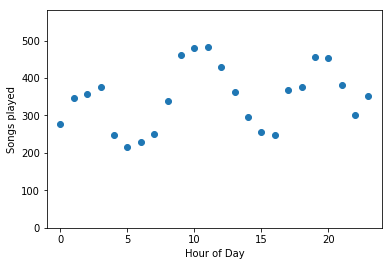

In [86]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour of Day")
plt.ylabel("Songs played");

## Drop Rows with Missing Values


In [20]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [21]:
user_log_valid.count()

10000

In [22]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [23]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [24]:
user_log_valid.count()

9664

## Users Downgrade Their Accounts

**Find when users downgrade their accounts to flag those log entries.** 

In [88]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|downgraded|phase|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+----------+-----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   6|         1|    1|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+--

In [26]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [94]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [95]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [96]:
user_log_valid.head()

Row(artist='Fabolous / The-Dream', auth='Logged In', firstName='Kevin', gender='M', itemInSession=1, lastName='Gilbert', length=231.54893, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1505550349284, sessionId=1435, song='Throw It In The Bag', status=200, ts=1513783259284, userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='1436', hour='10', downgraded=0, phase=0)

In [99]:
user_log_valid.select(["userId", "firstname", "page", "level", "song", "downgraded"]).where(user_log.userId == "1138").show(100)

+------+---------+----------------+-----+--------------------+----------+
|userId|firstname|            page|level|                song|downgraded|
+------+---------+----------------+-----+--------------------+----------+
|  1138|    Kelly|            Home| paid|                null|         0|
|  1138|    Kelly|        NextSong| paid| Everybody Everybody|         0|
|  1138|    Kelly|        NextSong| paid|               Gears|         0|
|  1138|    Kelly|        NextSong| paid|        Use Somebody|         0|
|  1138|    Kelly|        NextSong| paid|Love Of My Life (...|         0|
|  1138|    Kelly|        NextSong| paid|Down In The Valle...|         0|
|  1138|    Kelly|        NextSong| paid|Treat Her Like A ...|         0|
|  1138|    Kelly|        NextSong| paid|Everybody Thinks ...|         0|
|  1138|    Kelly|        NextSong| paid|      Fourteen Wives|         0|
|  1138|    Kelly|        NextSong| paid|   Love On The Rocks|         0|
|  1138|    Kelly|        NextSong| pa

#### Use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [100]:
from pyspark.sql import Window

In [101]:
Window.unboundedPreceding

-9223372036854775808

In [ ]:
# submit downgrade

In [32]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [33]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [34]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs